<a href="https://colab.research.google.com/github/mehakhafeez/NLPprojectweek6/blob/main/NLPprojectT5finalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install textblob nltk rouge-score


In [10]:
pip install rouge-score

In [11]:
pip install transformers==4.23.0

In [12]:
pip install sentencepiece==0.1.96

In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import torch
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
dataset1 = pd.read_csv('/content/1429_1.csv', quoting=3, on_bad_lines='skip')
# quoting=3 tells pandas to use the QUOTE_NONE strategy. This means that pandas will not treat any character as a quote character. This way if there are unclosed quotes, it ignores them.
# on_bad_lines='skip' replaces the deprecated 'error_bad_lines=False' to skip bad lines.
dataset2 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', quoting=3, on_bad_lines='skip')
dataset3 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', quoting=3, on_bad_lines='skip')

In [15]:
# Combine datasets
data = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)


In [16]:
# Data Cleaning
data = data.drop_duplicates()
data = data.dropna(subset=['reviews.text'])
data['reviews.text'] = data['reviews.text'].str.strip()
data['reviews.text'] = data['reviews.text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [17]:
# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

data['sentiment'] = data['reviews.text'].apply(get_sentiment)


In [18]:
# Display the first few rows of the dataset with the new 'sentiment' column
print(data[['reviews.text', 'sentiment']].head(10))

                                        reviews.text sentiment
0  This product so far has not disappointed My ch...  positive
1  great for beginner or experienced person Bough...  positive
2  Ive had my Fire HD  two weeks now and I love i...  positive
3  This amazon fire  inch tablet is the perfect s...  positive
4  I love ordering books and reading them with th...  positive
5  Not easy for elderly users cease of ads that p...  negative
6  Wanted my father to have his first tablet and ...  positive
7  Simply does everything I need Thank youAnd sil...   neutral
8  Got it as a present and love the size of the s...  positive
9  nice reader almost perfect for what i wantneed...  positive


In [19]:
# Sentiment Evaluation
X = data['reviews.text']
y = data['sentiment']

In [20]:
# Encode sentiments
y = y.map({'positive': 2, 'neutral': 1, 'negative': 0})

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [23]:
# Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)

y_pred_lr = lr_model.predict(X_test_vec)

In [24]:
# Evaluation Metrics for Logistic Regression
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Evaluation:
Accuracy: 0.9554247266610597
Precision: 0.9456877879922455
Recall: 0.9554247266610597
F1-Score: 0.9490820375826281
Confusion Matrix:
 [[  0   0  17]
 [  0 671  36]
 [  0   0 465]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       1.00      0.95      0.97       707
           2       0.90      1.00      0.95       465

    accuracy                           0.96      1189
   macro avg       0.63      0.65      0.64      1189
weighted avg       0.95      0.96      0.95      1189



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

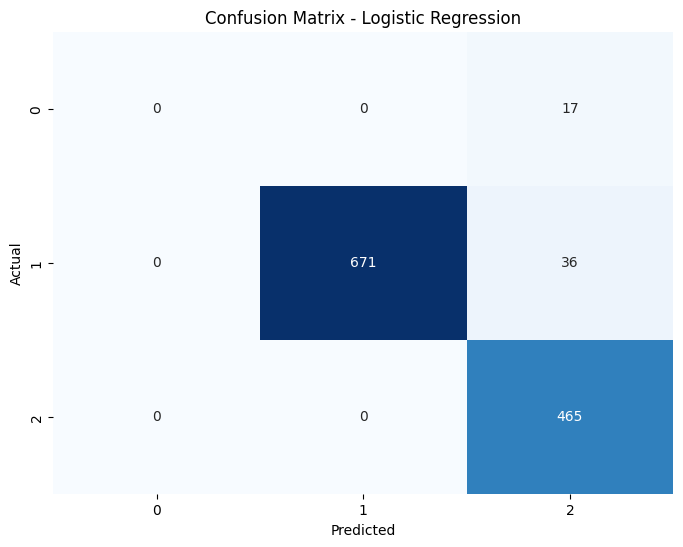

In [25]:
# Confusion Matrix Plot for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [26]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred_nb = nb_model.predict(X_test_vec)

In [27]:
# Evaluation Metrics for Naive Bayes
print("Naive Bayes Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Evaluation:
Accuracy: 0.9562657695542472
Precision: 0.9461649937888841
Recall: 0.9562657695542472
F1-Score: 0.9498588812552777
Confusion Matrix:
 [[  0   1  16]
 [  0 672  35]
 [  0   0 465]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       1.00      0.95      0.97       707
           2       0.90      1.00      0.95       465

    accuracy                           0.96      1189
   macro avg       0.63      0.65      0.64      1189
weighted avg       0.95      0.96      0.95      1189



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

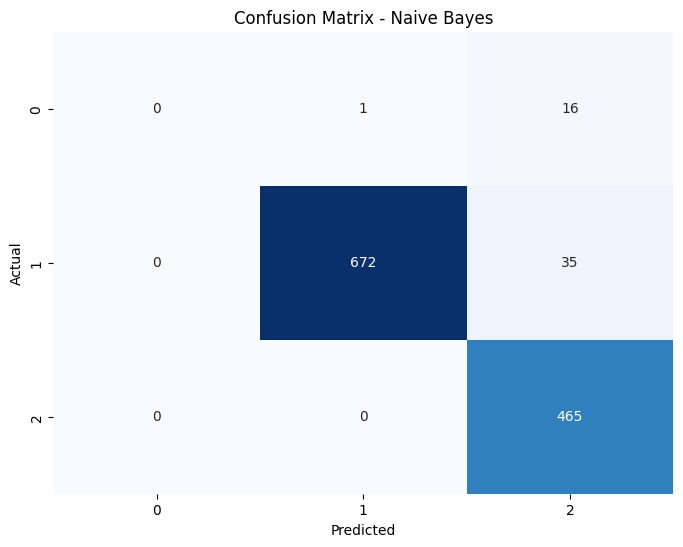

In [28]:
# Confusion Matrix Plot for Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# KMeans Clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_vec.toarray())

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_pca)


In [30]:
# Assign clusters to data
data['cluster'] = kmeans.predict(pca.transform(vectorizer.transform(data['reviews.text']).toarray()))

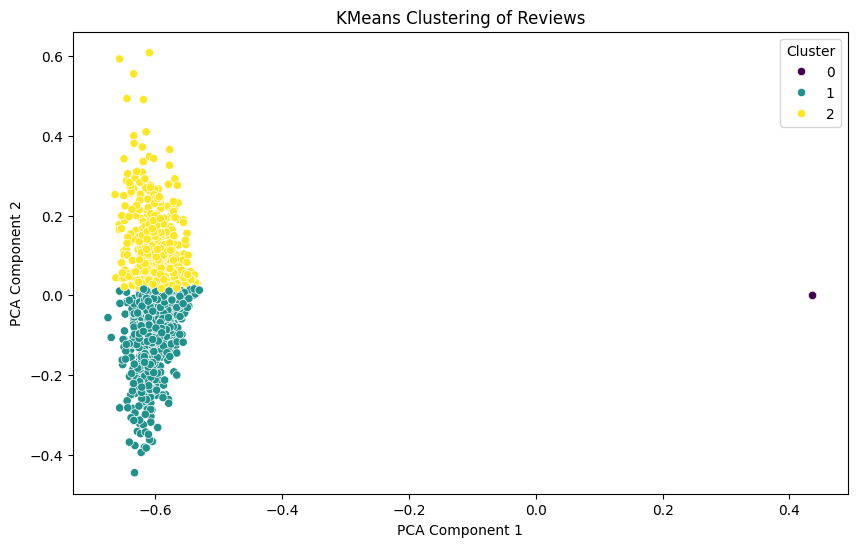

In [31]:
# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title("KMeans Clustering of Reviews")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [32]:
# Summarize Reviews into Articles using T5 Model
def generate_summary(texts, model, tokenizer, max_input_length=512, max_output_length=150):
    inputs = tokenizer.encode("summarize: " + ' '.join(texts), return_tensors="pt", max_length=max_input_length, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_output_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [33]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

print("T5 and tokenizer loaded successfully!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

T5 and tokenizer loaded successfully!


In [34]:
# Generate summaries for each cluster
for i in range(3):
    cluster_data = data[data['cluster'] == i]
    reviews = cluster_data['reviews.text'].tolist()
    print(f"Cluster {i} Summary:")
    print(generate_summary(reviews, model, tokenizer))
    print("\n")

Cluster 0 Summary:
httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBLHDMUO httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBLHDMUO httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBLHDMUO httpswwwamazoncomAmazonBasicsPerformanceAlkalineBatteriesCountdpBL


Cluster 1 Summary:
this amazon fire inch tablet is the perfect size I bought it for my husband so that he has a bigger screen than just his phone. my grandchildren are home schooled and use the tables for many learning apps They LOVE using them as it makes them feel so grown up.


Cluster 2 Summary:
great product Great tablet fast screen good size never gives me problem Does all basic functions of a tablet Hardcore users may want an iPad This fire tablet has long battery life Reasonable fast Sleek packaging easy set up and great for anyone who wants something to take along trips Great product Love the Amazon ecosystem The Freetime subscription is a must Great tablet but apps limited comp

In [35]:
# Install rouge-score if not already installed
# !pip install rouge-score

from rouge_score import rouge_scorer

# Rouge and BLEU Evaluation for Summaries
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
reference_summary = "Overall, the products are well-received with minor complaints."

for i in range(3):
    cluster_data = data[data['cluster'] == i]
    reviews = cluster_data['reviews.text'].tolist()
    generated_summary = generate_summary(reviews, model, tokenizer)

    # Calculate ROUGE scores
    scores = scorer.score(reference_summary, generated_summary)
    print(f"Cluster {i} ROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1']}")
    print(f"ROUGE-2: {scores['rouge2']}")
    print(f"ROUGE-L: {scores['rougeL']}")

    # Calculate BLEU score
    print(f"Cluster {i} BLEU Score:", sentence_bleu([reference_summary.split()], generated_summary.split()))
    print("\n")

Cluster 0 ROUGE Scores:
ROUGE-1: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.0, recall=0.0, fmeasure=0.0)
Cluster 0 BLEU Score: 0


Cluster 1 ROUGE Scores:
ROUGE-1: Score(precision=0.0392156862745098, recall=0.2222222222222222, fmeasure=0.06666666666666667)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.0392156862745098, recall=0.2222222222222222, fmeasure=0.06666666666666667)
Cluster 1 BLEU Score: 8.107244643554327e-232




/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Cluster 2 ROUGE Scores:
ROUGE-1: Score(precision=0.029411764705882353, recall=0.3333333333333333, fmeasure=0.05405405405405406)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.0196078431372549, recall=0.2222222222222222, fmeasure=0.036036036036036036)
Cluster 2 BLEU Score: 6.817352958349419e-232




In [36]:
# Fine-tune T5 Model for Product Review Generation
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, summaries, tokenizer, max_length=512):
        self.reviews = reviews
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        summary = self.summaries[index]

        inputs = self.tokenizer("summarize: " + review, max_length=self.max_length, truncation=True, return_tensors="pt")
        labels = self.tokenizer(summary, max_length=150, truncation=True, return_tensors="pt")

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze()
        }

In [37]:
# Prepare dataset for fine-tuning
summaries = ["Excellent product with high quality." for _ in range(len(data))]
dataset = ReviewsDataset(data['reviews.text'].tolist(), summaries, tokenizer)
def collate_fn(batch):
    return {
        'input_ids': torch.nn.utils.rnn.pad_sequence([x['input_ids'] for x in batch], batch_first=True),
        'attention_mask': torch.nn.utils.rnn.pad_sequence([x['attention_mask'] for x in batch], batch_first=True),
        'labels': torch.nn.utils.rnn.pad_sequence([x['labels'] for x in batch], batch_first=True)
    }

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500
)

def model_init():
    return T5ForConditionalGeneration.from_pretrained("t5-small")

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn
)

trainer.train()


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--t5-small/snapshots/df1b051c49625cf57a3d0d8d3863ed4d13564fe4/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefi

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=496, training_loss=0.19691619565409998, metrics={'train_runtime': 580.8049, 'train_samples_per_second': 6.822, 'train_steps_per_second': 0.854, 'total_flos': 45650366693376.0, 'train_loss': 0.19691619565409998, 'epoch': 1.0})

In [40]:
# Test fine-tuned model on a sample
sample_input = "This product is amazing and exceeded all my expectations."
inputs = tokenizer.encode("summarize: " + sample_input, return_tensors="pt")

# Move inputs to the same device as the model
if torch.cuda.is_available():
    inputs = inputs.to(trainer.model.device)  # Move inputs to GPU

predicted_summary_ids = trainer.model.generate(inputs, max_length=150, num_beams=4, early_stopping=True)
predicted_summary = tokenizer.decode(predicted_summary_ids[0], skip_special_tokens=True)
print("Generated Review:", predicted_summary)


Generated Review: Excellent product with high quality.


In [42]:
# Generate summaries for the fine-tuned model and evaluate using ROUGE and BLEU
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
reference_summary = "Excellent product with high quality."

# Sample input for testing the fine-tuned model
sample_input = "This product is amazing and exceeded all my expectations."
inputs = tokenizer.encode("summarize: " + sample_input, return_tensors="pt")

# Move inputs to the same device as the model
if torch.cuda.is_available():
    inputs = inputs.to(trainer.model.device)  # Move inputs to GPU if available

# Generate summary from the fine-tuned model
generated_summary_ids = trainer.model.generate(inputs, max_length=150, num_beams=4, early_stopping=True)
generated_summary = tokenizer.decode(generated_summary_ids[0], skip_special_tokens=True)

# Calculate ROUGE scores
scores = scorer.score(reference_summary, generated_summary)
print("ROUGE Scores for Fine-Tuned Model:")
print(f"ROUGE-1: {scores['rouge1']}")
print(f"ROUGE-2: {scores['rouge2']}")
print(f"ROUGE-L: {scores['rougeL']}")

# Calculate BLEU score
print(f"BLEU Score for Fine-Tuned Model:", sentence_bleu([reference_summary.split()], generated_summary.split()))

ROUGE Scores for Fine-Tuned Model:
ROUGE-1: Score(precision=1.0, recall=1.0, fmeasure=1.0)
ROUGE-2: Score(precision=1.0, recall=1.0, fmeasure=1.0)
ROUGE-L: Score(precision=1.0, recall=1.0, fmeasure=1.0)
BLEU Score for Fine-Tuned Model: 1.0
